In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from missforest import MissForest
from scipy.stats import ks_2samp
from sklearn.metrics import mean_absolute_error
import random


In [32]:
def plot_distributions(original, imputed, variable):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(original[variable].dropna(), label='Original', color='blue')
    sns.kdeplot(imputed[variable], label='Imputed', color='red')
    plt.title(f'Distribution of {variable}')
    plt.legend()
    plt.show()


In [3]:
# Load the dataset
data = pd.read_csv('rad_clin_feats_PFS_OS.csv')

# Explore the data
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Columns: 1146 entries, MPC to wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis
dtypes: float64(1135), int64(2), object(9)
memory usage: 1.9+ MB
None


Count: The number of non-null entries for each column.
Mean: The average value of each column.
Standard Deviation (std): The spread of the data around the mean.
Minimum (min): The smallest value in each column.
25th Percentile (25%): The value below which 25% of the data falls.
Median (50%): The middle value of the data (also known as the 50th percentile).
75th Percentile (75%): The value below which 75% of the data falls.
Maximum (max): The largest value in each column.

In [4]:
print(data.describe())


       PFS_I_EVENT  PFS_I_MONTHS    OS_EVENT    OS_MONTH         AGE  \
count   221.000000    221.000000  221.000000  221.000000  221.000000   
mean      0.723982     33.886878    0.352941   55.556561   62.619910   
std       0.448041     22.698035    0.478969   36.394964    9.791479   
min       0.000000      0.000000    0.000000    1.000000   27.000000   
25%       0.000000     19.000000    0.000000   31.000000   57.000000   
50%       1.000000     30.000000    0.000000   47.000000   63.000000   
75%       1.000000     44.000000    1.000000   74.000000   69.000000   
max       1.000000    144.000000    1.000000  202.000000   84.000000   

       original_shape_Elongation  original_shape_Flatness  \
count                 221.000000               221.000000   
mean                    0.382410                 0.170131   
std                     0.047810                 0.035361   
min                     0.292365                 0.116072   
25%                     0.345136              

In [5]:
print(data.head())

       MPC  PFS_I_EVENT  PFS_I_MONTHS  OS_EVENT  OS_MONTH  PLT    HB   AGE  \
0  MPC_269            1          21.0         1      46.0   nv    nv  27.0   
1  MPC_538            1           0.0         1       1.0  525  10.8  46.0   
2  MPC_427            0          26.0         0      26.0  294  11.3  59.0   
3  MPC_375            0          55.0         0      55.0  275    13  54.0   
4  MPC_483            1           3.0         1      29.0  227  10.7  61.0   

  R_ISS SEX  ... wavelet-LLL_gldm_GrayLevelNonUniformity  \
0     3   M  ...                            12250.561427   
1     2   M  ...                            23119.731466   
2     1   F  ...                             5190.872145   
3     1   M  ...                            10686.293903   
4     1   F  ...                             8358.801039   

  wavelet-LLL_gldm_GrayLevelVariance wavelet-LLL_gldm_HighGrayLevelEmphasis  \
0                         886.146115                            5103.874879   
1           

In [6]:
print(data.isnull().sum())

MPC                                                      0
PFS_I_EVENT                                              0
PFS_I_MONTHS                                             0
OS_EVENT                                                 0
OS_MONTH                                                 0
                                                        ..
wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmphasis     0
wavelet-LLL_gldm_LowGrayLevelEmphasis                    0
wavelet-LLL_gldm_SmallDependenceEmphasis                 0
wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis    0
wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis     0
Length: 1146, dtype: int64


In [7]:
data= data.replace('nv', np.nan)

In [8]:
# Identify columns with missing values
missing_columns = data.columns[data.isnull().sum() != 0]

# Print the columns with missing values and their respective counts
for col in missing_columns:
    print(f'{col}: {data[col].isnull().sum()}')
    print(f'{col}: {data[col].describe()}')
    

PLT: 2
PLT: count     219
unique    152
top       227
freq        4
Name: PLT, dtype: object
HB: 2
HB: count      219
unique      80
top       10.8
freq         9
Name: HB, dtype: object
R_ISS: 59
R_ISS: count     162
unique      3
top         2
freq       92
Name: R_ISS, dtype: object
CREATININE: 1
CREATININE: count     220
unique    113
top       0.8
freq        9
Name: CREATININE, dtype: object
Clearence: 159
Clearence: count     62
unique    42
top       90
freq       4
Name: Clearence, dtype: object
PC_TOT: 35
PC_TOT: count     186
unique     20
top        20
freq       30
Name: PC_TOT, dtype: object
CALCIUM: 28
CALCIUM: count     193
unique     41
top       9.7
freq       14
Name: CALCIUM, dtype: object


In [9]:
# Explore the data
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Columns: 1146 entries, MPC to wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis
dtypes: float64(1135), int64(2), object(9)
memory usage: 1.9+ MB
None


In [10]:
data['Clearence'] = pd.to_numeric(data['Clearence'], errors='coerce')

# Count values higher than 50
higher_than_50 = (data['Clearence'] > 50).sum()

# Count values lower than 50
lower_than_50 = (data['Clearence'] < 50).sum()

# Count NaN values
nan_values = data['Clearence'].isna().sum()

mean=data['Clearence'].mean()
mass=data['Clearence'].max()
min=data['Clearence'].min()

print(f"Values higher than 50: {higher_than_50}")
print(f"Values lower than 50: {lower_than_50}")
print(f"NaN values: {nan_values}")
print(f"Mean values: {mean}")
print(f"Max values: {mass}")
print(f"Min values: {min}")

Values higher than 50: 56
Values lower than 50: 6
NaN values: 159
Mean values: 86.49838709677418
Max values: 120.0
Min values: 4.0


In [ ]:
# # Extract rows where 'Clearence' is NaN
# nan_rows = data[data['Clearence'].isna()]
# print(data['AGE'].info())


# # Select 'Sex', 'Age', and 'Creatinine' columns
# nan_info = nan_rows[['SEX', 'AGE', 'CREATININE']]

# print(nan_info)

In [ ]:
# # Handle missing values (example: fill with mean)
# data.fillna(data.mean(), inplace=True)

# # Scale the features
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(data)

# # Convert scaled data back to a DataFrame
# scaled_data = pd.DataFrame(scaled_data, columns=data.columns)


In [11]:
print(data['SEX'])

0      M
1      M
2      F
3      M
4      F
      ..
216    M
217    M
218    F
219    M
220    M
Name: SEX, Length: 221, dtype: object


In [12]:
# Binarize categorical variables. Creatinine is binerized in 1 if
#high values or 0 for normal values
data['SEX'] = data['SEX'].map({'M': 1, 'F': 0})
# Converte la colonna 'creatinine' in valori numerici, ignorando eventuali errori
#data['CREATININE'] = pd.to_numeric(data['CREATININE'], errors='coerce')
#data['CREATININE'] = (data['CREATININE'] > 2).astype(int)



In [13]:
print(data['SEX'])

0      1
1      1
2      0
3      1
4      0
      ..
216    1
217    1
218    0
219    1
220    1
Name: SEX, Length: 221, dtype: int64


In [14]:
data['PC_TOT'] = pd.to_numeric(data['PC_TOT'], errors='coerce')

# Count values higher than 50
higher_than_50 = (data['PC_TOT'] > 60).sum()

# Count values lower than 50
lower_than_50 = (data['PC_TOT'] < 60).sum()

# Count NaN values
nan_values = data['PC_TOT'].isna().sum()

mean=data['PC_TOT'].mean()
mass=data['PC_TOT'].max()
min=data['PC_TOT'].min()

print(f"Values higher than 50: {higher_than_50}")
print(f"Values lower than 50: {lower_than_50}")
print(f"NaN values: {nan_values}")
print(f"Mean values: {mean}")
print(f"Max values: {mass}")
print(f"Min values: {min}")

Values higher than 50: 67
Values lower than 50: 110
NaN values: 35
Mean values: 50.075268817204304
Max values: 100.0
Min values: 5.0


In [15]:
# Converti tutte le colonne in numerico
data = data.apply(pd.to_numeric, errors='coerce')

In [16]:
# Function to identify categorical variables with values 0 or 1
def find_binary_categorical_vars(df):
    binary_categorical_vars = []
    for col in df.columns:
        if df[col].dropna().isin([0, 1]).all():
            binary_categorical_vars.append(col)
    return binary_categorical_vars

# Identify binary categorical variables
binary_categorical_vars = find_binary_categorical_vars(data)

print("Categorical variables with values 0 or 1 are:", binary_categorical_vars)

Categorical variables with values 0 or 1 are: ['MPC', 'PFS_I_EVENT', 'OS_EVENT', 'SEX']


In [17]:
# Rimotion of 'MPC' column because there are the identification number of the patient, not useful for my analysis
data = data.drop(columns=['MPC'])


In [18]:
# Identify binary categorical variables
binary_categorical_vars = find_binary_categorical_vars(data)

print("Categorical variables with values 0 or 1 are:", binary_categorical_vars)

Categorical variables with values 0 or 1 are: ['PFS_I_EVENT', 'OS_EVENT', 'SEX']


In [19]:
# Calcola la matrice di correlazione
correlation_matrix = data.corr()

# Visualizza la matrice per ispezionare le correlazioni
print(correlation_matrix)


                                                    PFS_I_EVENT  PFS_I_MONTHS  \
PFS_I_EVENT                                            1.000000     -0.047781   
PFS_I_MONTHS                                          -0.047781      1.000000   
OS_EVENT                                               0.456020     -0.225430   
OS_MONTH                                               0.340064      0.714407   
PLT                                                   -0.176035      0.174898   
...                                                         ...           ...   
wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmp...    -0.156334     -0.073594   
wavelet-LLL_gldm_LowGrayLevelEmphasis                 -0.166974     -0.092130   
wavelet-LLL_gldm_SmallDependenceEmphasis              -0.118008     -0.064112   
wavelet-LLL_gldm_SmallDependenceHighGrayLevelEm...     0.173321      0.061961   
wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmp...    -0.167827     -0.105253   

                           

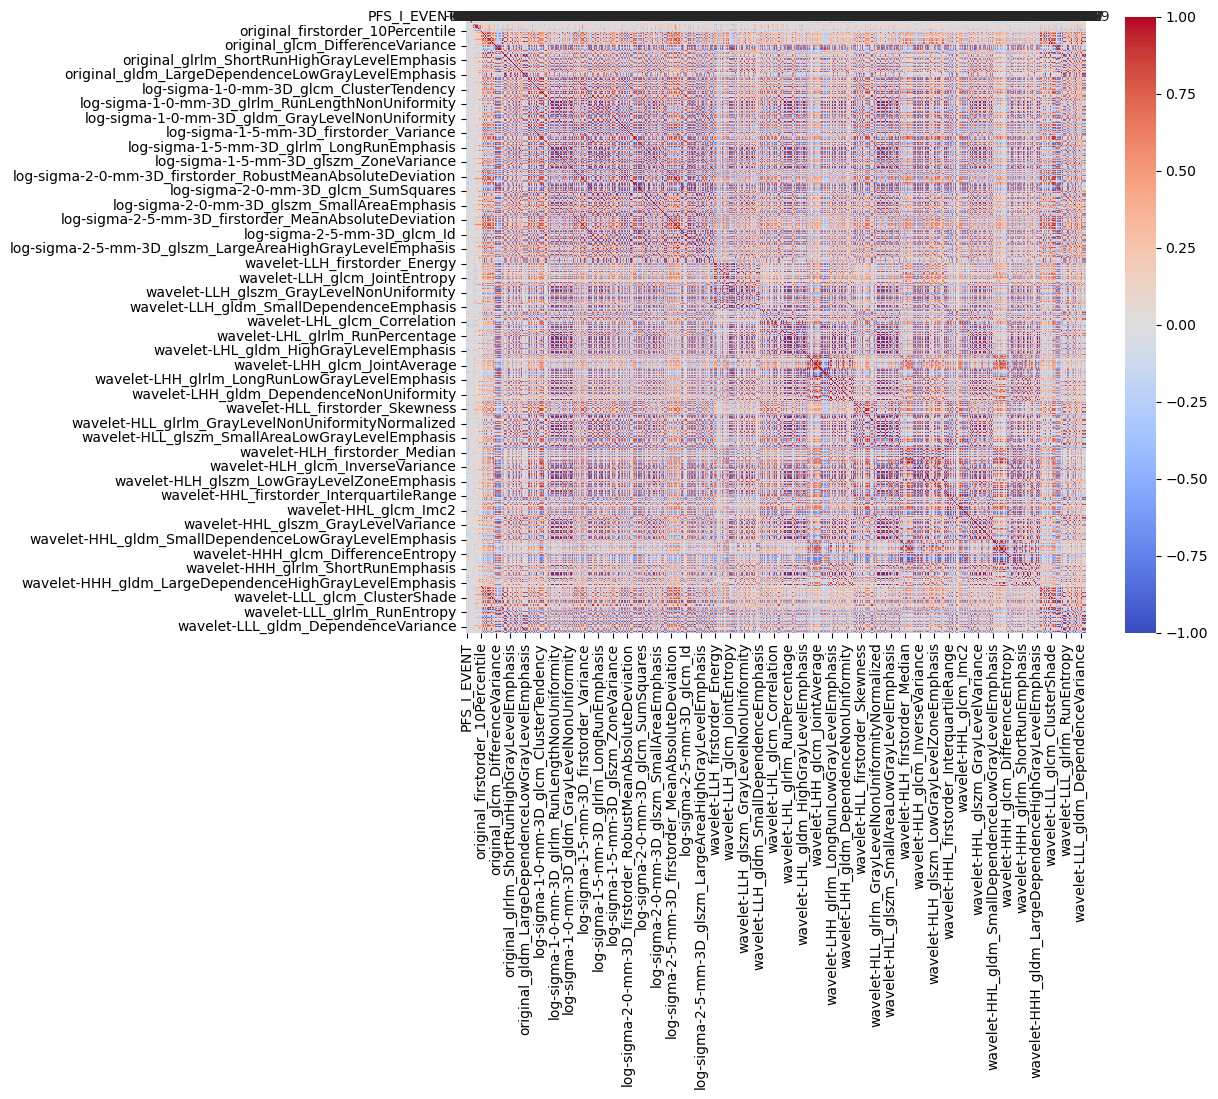

In [20]:
# Mappa di calore per visualizzare le correlazioni
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()


In [33]:
# # Assuming your correlation matrix is saved as `corr_matrix`
# # Filter pairs with correlation > 0.9
# high_corr_pairs = []
# threshold = 0.9

# # Iterate over the correlation matrix to get high correlations
# for i in range(len(correlation_matrix.columns)):
#     for j in range(i + 1, len(correlation_matrix.columns)):
#         if abs(correlation_matrix.iloc[i, j]) > threshold:
#             var1 = correlation_matrix.columns[i]
#             var2 = correlation_matrix.columns[j]
#             corr_value = correlation_matrix.iloc[i, j]
#             high_corr_pairs.append((var1, var2, corr_value))

# # Convert the result to a DataFrame for readability
# high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Variable 1', 'Variable 2', 'Correlation'])

# # Display the pairs with high correlation
# print(high_corr_df)


                                              Variable 1  \
0                         original_shape_MajorAxisLength   
1                         original_shape_MajorAxisLength   
2                    original_shape_Maximum2DDiameterRow   
3                              original_shape_MeshVolume   
4                              original_shape_MeshVolume   
...                                                  ...   
20500             wavelet-LLL_gldm_HighGrayLevelEmphasis   
20501             wavelet-LLL_gldm_HighGrayLevelEmphasis   
20502  wavelet-LLL_gldm_LargeDependenceHighGrayLevelE...   
20503  wavelet-LLL_gldm_LargeDependenceLowGrayLevelEm...   
20504              wavelet-LLL_gldm_LowGrayLevelEmphasis   

                                              Variable 2  Correlation  
0                    original_shape_Maximum2DDiameterRow     0.910457  
1                       original_shape_Maximum3DDiameter     0.921443  
2                       original_shape_Maximum3DDiameter     0.

In [162]:
variables_to_check = ['PLT', 'HB', 'R_ISS', 'CREATININE', 'PC_TOT', 'CALCIUM', 'Clearence']

In [22]:
for variable in variables_to_check:
    print(variable)
    # Estrai le correlazioni della variabile con tutte le altre variabili
    variable_corr = correlation_matrix[variable]

    # Converti il risultato in un DataFrame per una migliore leggibilità
    variable_corr_df = variable_corr.reset_index()
    variable_corr_df.columns = ['Variable', 'Correlation']

    # Inizializza le liste per memorizzare le variabili in base alla forza della correlazione
    very_weak_or_none = []
    weak = []
    moderate = []
    strong = []
    very_strong = []

    # Classifica le variabili in base alla forza della correlazione
    for index, row in variable_corr_df.iterrows():
        if -0.1 <= row['Correlation'] <= 0.1:
            very_weak_or_none.append((row['Variable'], row['Correlation']))
        elif 0.1 < row['Correlation'] <= 0.3 or -0.3 <= row['Correlation'] < -0.1:
            weak.append((row['Variable'], row['Correlation']))
        elif 0.3 < row['Correlation'] <= 0.5 or -0.5 <= row['Correlation'] < -0.3:
            moderate.append((row['Variable'], row['Correlation']))
        elif 0.5 < row['Correlation'] <= 0.7 or -0.7 <= row['Correlation'] < -0.5:
            strong.append((row['Variable'], row['Correlation']))
        elif row['Correlation'] > 0.7 or row['Correlation'] < -0.7:
            very_strong.append((row['Variable'], row['Correlation']))

    # Stampa i risultati
#     print(f"\nCorrelations for {variable}:")

    print("Very weak or no correlation (-0.1 to 0.1):")
#     for var, corr in very_weak_or_none:
#         print(f"{var}: {corr}")
    print(f"Total: {len(very_weak_or_none)} variables\n")

    print("Weak correlation (0.1 to 0.3 or -0.1 to -0.3):")
#     for var, corr in weak:
#         print(f"{var}: {corr}")
    print(f"Total: {len(weak)} variables\n")

    print("Moderate correlation (0.3 to 0.5 or -0.3 to -0.5):")
    for var, corr in moderate:
        print(f"{var}: {corr}")
    print(f"Total: {len(moderate)} variables\n")

    print("Strong correlation (0.5 to 0.7 or -0.5 to -0.7):")
    for var, corr in strong:
        print(f"{var}: {corr}")
    print(f"Total: {len(strong)} variables\n")

    print("Very strong correlation (> 0.7 or < -0.7):")
    for var, corr in very_strong:
        print(f"{var}: {corr}")
    print(f"Total: {len(very_strong)} variables\n")


PLT
Very weak or no correlation (-0.1 to 0.1):
Total: 961 variables

Weak correlation (0.1 to 0.3 or -0.1 to -0.3):
Total: 183 variables

Moderate correlation (0.3 to 0.5 or -0.3 to -0.5):
Total: 0 variables

Strong correlation (0.5 to 0.7 or -0.5 to -0.7):
Total: 0 variables

Very strong correlation (> 0.7 or < -0.7):
PLT: 1.0
Total: 1 variables

HB
Very weak or no correlation (-0.1 to 0.1):
Total: 1116 variables

Weak correlation (0.1 to 0.3 or -0.1 to -0.3):
Total: 26 variables

Moderate correlation (0.3 to 0.5 or -0.3 to -0.5):
R_ISS: -0.45701092884455763
PC_TOT: -0.4378661943346367
Total: 2 variables

Strong correlation (0.5 to 0.7 or -0.5 to -0.7):
Total: 0 variables

Very strong correlation (> 0.7 or < -0.7):
HB: 1.0
Total: 1 variables

R_ISS
Very weak or no correlation (-0.1 to 0.1):
Total: 814 variables

Weak correlation (0.1 to 0.3 or -0.1 to -0.3):
Total: 325 variables

Moderate correlation (0.3 to 0.5 or -0.3 to -0.5):
PFS_I_EVENT: 0.31896860775626823
OS_EVENT: 0.3704376472

In [23]:
# Split dataset into train and test sets.
train, test = train_test_split(data, test_size=.3, shuffle=True,
                               random_state=42)

# Default estimators are lgbm classifier and regressor
mf = MissForest()
mf.fit(
    x=train,
    categorical=["PFS_I_EVENT", "OS_EVENT", "SEX"]
)
train_imputed = mf.transform(x=train)
test_imputed = mf.transform(x=test)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.49it/s]


In [24]:
print(train_imputed)

     PFS_I_EVENT  PFS_I_MONTHS  OS_EVENT  OS_MONTH    PLT    HB   AGE  \
65             0          24.0         0      24.0  301.0  13.6  66.0   
112            1          23.0         1      41.0  118.0   8.9  71.0   
186            1          40.0         0      90.0  243.0   8.9  49.0   
155            1          43.0         0      87.0  256.0  10.5  62.0   
31             0          12.0         0      12.0  237.0  12.5  58.0   
..           ...           ...       ...       ...    ...   ...   ...   
106            1          92.0         0     177.0  300.0  11.4  53.0   
14             0          38.0         0      38.0  253.0  15.2  68.0   
92             0          52.0         0      52.0  236.0  12.3  52.0   
179            1          36.0         1      67.0  143.0   9.6  68.0   
102            1          28.0         1      52.0  178.0  11.9  59.0   

        R_ISS  SEX  CREATININE  ...  wavelet-LLL_gldm_GrayLevelNonUniformity  \
65   2.000000    0        0.52  ...        

In [25]:
print(test_imputed)

     PFS_I_EVENT  PFS_I_MONTHS  OS_EVENT  OS_MONTH    PLT    HB   AGE  \
132            1          48.0         0      54.0  217.0  12.3  68.0   
148            1          19.0         1      92.0  216.0  13.6  56.0   
93             1          30.0         0      38.0  340.0   9.3  66.0   
180            1          31.0         1      35.0  191.0  11.3  75.0   
15             1          21.0         1      46.0  270.0  15.2  63.0   
..           ...           ...       ...       ...    ...   ...   ...   
139            0          10.0         0      10.0  144.0  14.6  45.0   
56             0          22.0         0      22.0  243.0  12.4  49.0   
156            1          46.0         1      74.0  165.0  13.2  51.0   
176            1          35.0         0      47.0  228.0  10.7  59.0   
163            1          78.0         0      88.0  251.0  12.5  57.0   

        R_ISS  SEX  CREATININE  ...  wavelet-LLL_gldm_GrayLevelNonUniformity  \
132  2.000000    0        0.59  ...        

In [26]:
# Identify columns with missing values
missing_columns = train_imputed.columns[train_imputed.isnull().sum() != 0]

# Print the columns with missing values and their respective counts
for col in missing_columns:
    print(f'{col}: {train_imputed[col].isnull().sum()}')
    print(f'{col}: {train_imputed[col].describe()}')
    

In [159]:
# Unisci i due dataframe mantenendo gli indici originali
imputed_data = pd.concat([train_imputed, test_imputed])

# Ordina gli indici in ordine crescente
imputed_data = imputed_data.sort_index()



     PFS_I_EVENT  PFS_I_MONTHS  OS_EVENT  OS_MONTH         PLT         HB  \
0              1          21.0         1      46.0  254.984034  11.258796   
1              1           0.0         1       1.0  525.000000  10.800000   
2              0          26.0         0      26.0  294.000000  11.300000   
3              0          55.0         0      55.0  275.000000  13.000000   
4              1           3.0         1      29.0  227.000000  10.700000   
..           ...           ...       ...       ...         ...        ...   
216            1          41.0         0      50.0  289.000000  13.400000   
217            1          37.0         1      43.0   69.000000   9.300000   
218            1          20.0         0      59.0  241.000000  11.000000   
219            1          21.0         1      80.0  281.000000   8.700000   
220            1           7.0         0      53.0  114.000000   6.900000   

      AGE     R_ISS  SEX  CREATININE  ...  \
0    27.0  3.000000    1      

In [27]:
print(train_imputed.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154 entries, 65 to 102
Columns: 1145 entries, PFS_I_EVENT to wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis
dtypes: float64(1142), int64(3)
memory usage: 1.4 MB
None


In [28]:
print(test_imputed.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67 entries, 132 to 163
Columns: 1145 entries, PFS_I_EVENT to wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis
dtypes: float64(1142), int64(3)
memory usage: 601.9 KB
None


In [29]:
# Identify columns with missing values
missing_columns = imputed_data.columns[imputed_data.isnull().sum() != 0]

# Print the columns with missing values and their respective counts
for col in missing_columns:
    print(f'{col}: {imputed_data[col].isnull().sum()}')
    print(f'{col}: {imputed_data[col].describe()}')
    

In [30]:
# Verifica il risultato
print(imputed_data.head())

   PFS_I_EVENT  PFS_I_MONTHS  OS_EVENT  OS_MONTH    PLT    HB   AGE     R_ISS  \
0            0          24.0         0      24.0  301.0  13.6  66.0  2.000000   
1            1          23.0         1      41.0  118.0   8.9  71.0  2.000000   
2            1          40.0         0      90.0  243.0   8.9  49.0  2.162298   
3            1          43.0         0      87.0  256.0  10.5  62.0  2.000000   
4            0          12.0         0      12.0  237.0  12.5  58.0  2.000000   

   SEX  CREATININE  ...  wavelet-LLL_gldm_GrayLevelNonUniformity  \
0    0        0.52  ...                              7961.609337   
1    0        0.95  ...                             12214.283000   
2    1        1.04  ...                             11858.427453   
3    0        0.68  ...                              9470.356932   
4    1        0.83  ...                             23214.809001   

   wavelet-LLL_gldm_GrayLevelVariance  wavelet-LLL_gldm_HighGrayLevelEmphasis  \
0                      

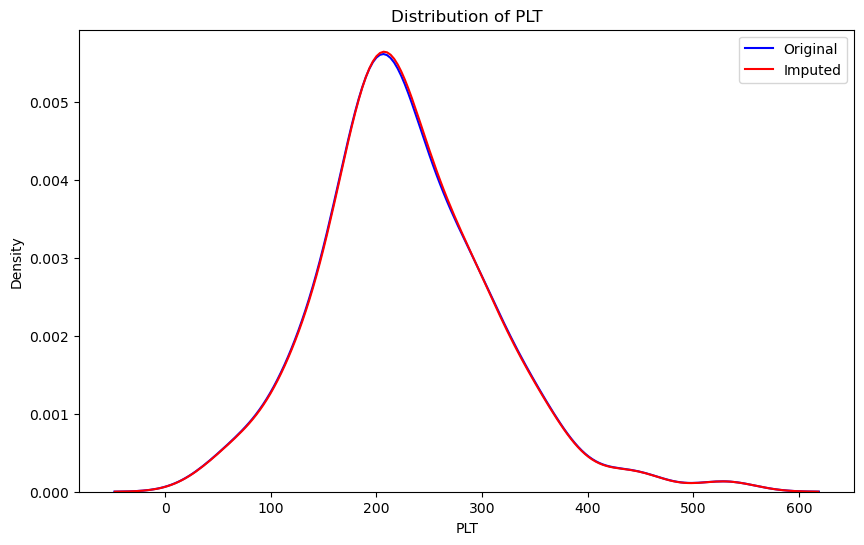

KS Test for PLT: KS Statistic = 0.004876133804417446, p-value = 1.0
The result for PLT is not significant after Bonferroni correction.


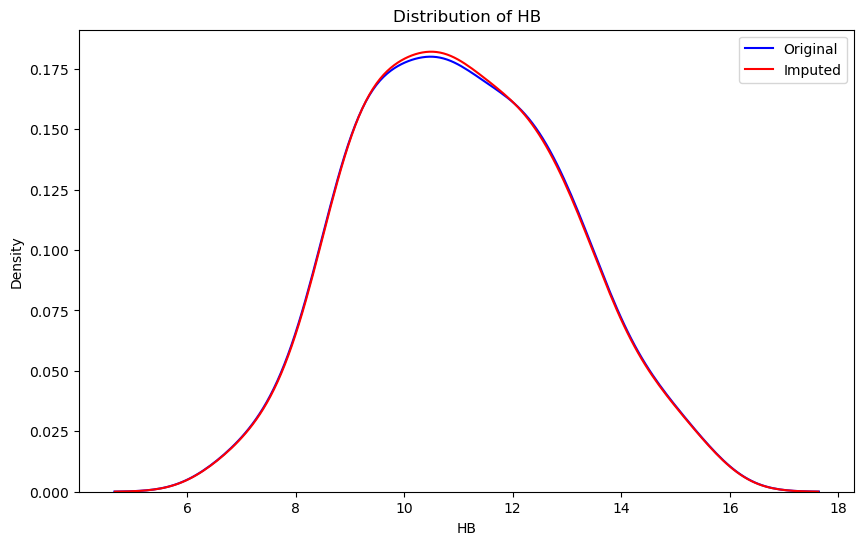

KS Test for HB: KS Statistic = 0.004214963119072708, p-value = 1.0
The result for HB is not significant after Bonferroni correction.


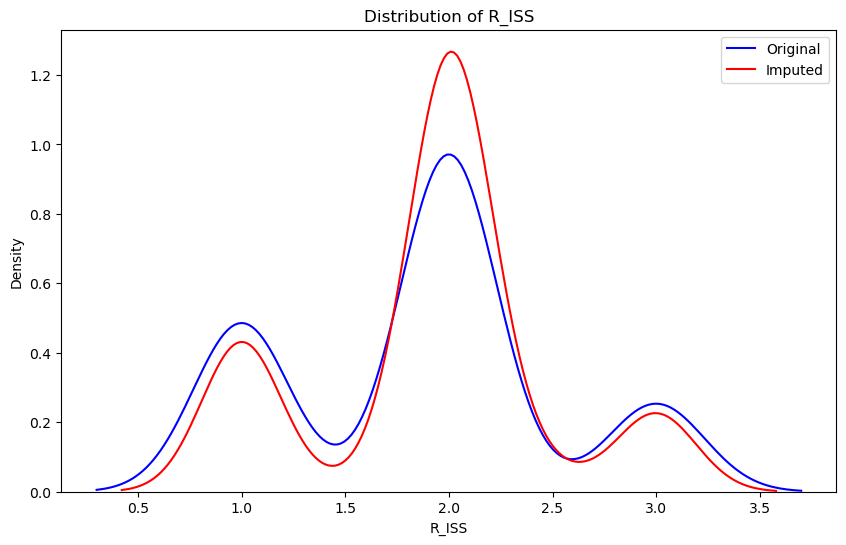

KS Test for R_ISS: KS Statistic = 0.14144461203284733, p-value = 0.0417200777658347
The result for R_ISS is not significant after Bonferroni correction.


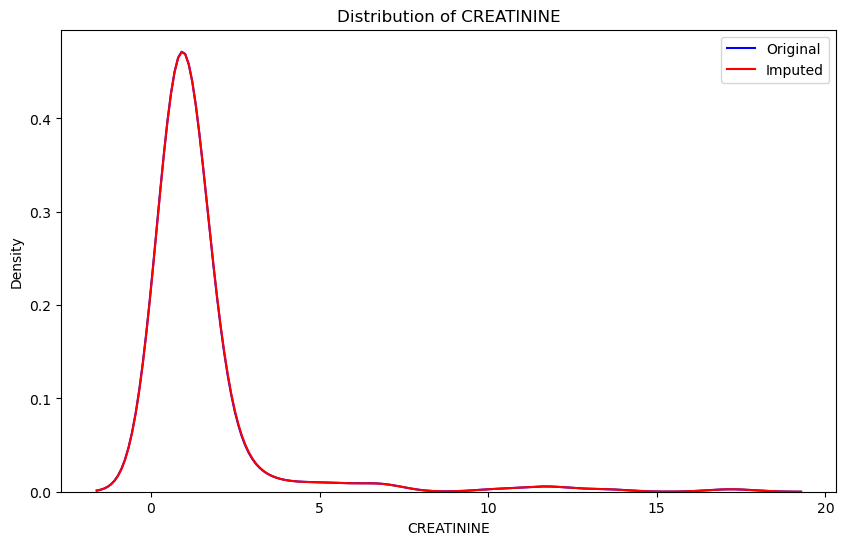

KS Test for CREATININE: KS Statistic = 0.004072398190045249, p-value = 1.0
The result for CREATININE is not significant after Bonferroni correction.


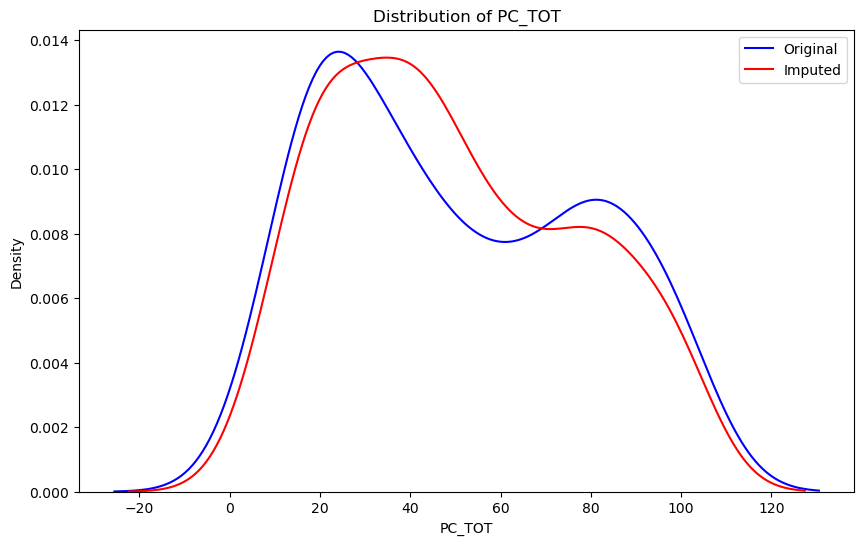

KS Test for PC_TOT: KS Statistic = 0.05592857490390697, p-value = 0.8860434005757502
The result for PC_TOT is not significant after Bonferroni correction.


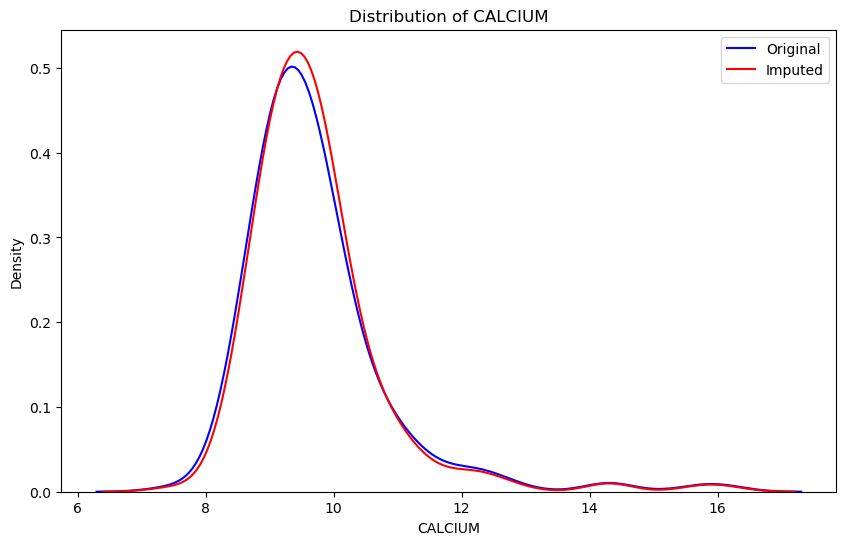

KS Test for CALCIUM: KS Statistic = 0.03462827937073594, p-value = 0.9991000163084013
The result for CALCIUM is not significant after Bonferroni correction.


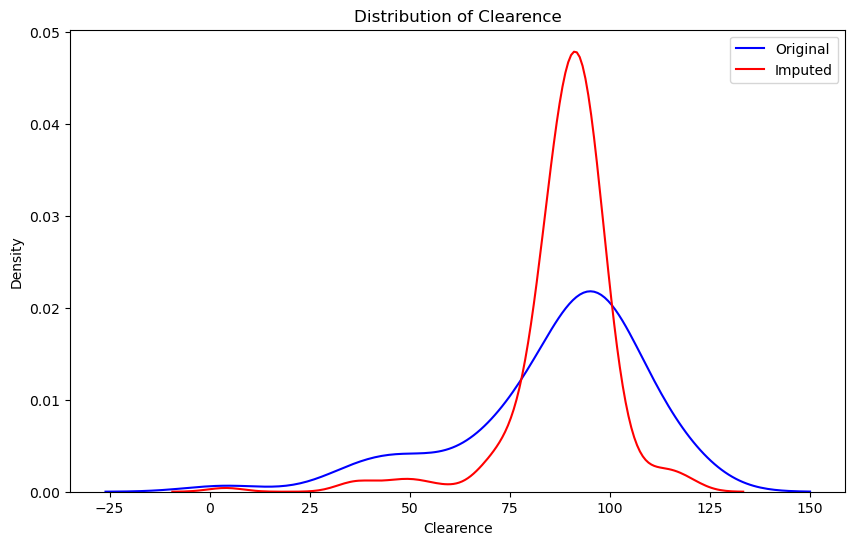

KS Test for Clearence: KS Statistic = 0.2539045394832871, p-value = 0.0030292016288718626
The result for Clearence is significant after Bonferroni correction.


In [163]:
# Supponiamo che `variables_to_check` sia la lista delle variabili per cui stai eseguendo il test
alpha_originale = 0.05
alpha_nuovo = alpha_originale / len(variables_to_check)

for variable in variables_to_check:
    # Esempio per una variabile specifica
    plot_distributions(data, imputed_data, variable)

    # Test di Kolmogorov-Smirnov per una variabile specifica
    ks_stat, p_value = ks_2samp(data[variable].dropna(), imputed_data[variable])
    print(f"KS Test for {variable}: KS Statistic = {ks_stat}, p-value = {p_value}")
    
    # Verifica se il p-value è significativo con la correzione di Bonferroni
    if p_value < alpha_nuovo:
        print(f"The result for {variable} is significant after Bonferroni correction.")
    else:
        print(f"The result for {variable} is not significant after Bonferroni correction.")


In [164]:
# Funzione per confrontare le matrici di correlazione e stampare i valori e la variabile con il valore massimo
def compare_correlations(original, imputed):
    original_corr = original.corr()
    imputed_corr = imputed.corr()
    comparison = original_corr - imputed_corr
    
    # Trova il valore massimo e la variabile corrispondente
    max_value = comparison.max().max()
    max_variable = comparison.stack().idxmax()
    
    print(f"Max value: {max_value}")
    print(f"Variable pair with max value: {max_variable}")
    
    return comparison

# Supponendo che `data` sia il DataFrame originale con dati mancanti
# e `imputed_data` sia il DataFrame con i dati imputati

# Esempio di utilizzo della funzione
# Confronto delle matrici di correlazione
corr_comparison = compare_correlations(data, imputed_data)


Max value: 0.16989148869810963
Variable pair with max value: ('Clearence', 'wavelet-LHH_firstorder_Minimum')


In [165]:
import pandas as pd

# Funzione per confrontare le statistiche descrittive e stampare i valori e la variabile con il valore massimo
def compare_statistics(original, imputed):
    original_stats = original.describe()
    imputed_stats = imputed.describe()
    comparison = original_stats - imputed_stats
    
    # Trova il valore massimo e la variabile corrispondente
    max_value = comparison.max().max()
    max_variable = comparison.max().idxmax()
    
    print(f"Max value: {max_value}")
    print(f"Variable with max value: {max_variable}")
    
    return comparison

# Supponendo che `data` sia il DataFrame originale con dati mancanti
# e `imputed_data` sia il DataFrame con i dati imputati

# Esempio di utilizzo della funzione
# Confronto delle statistiche descrittive
stats_comparison = compare_statistics(data, imputed_data)


Max value: 10.0
Variable with max value: PC_TOT


In [166]:
data['CREATININE'] = (data['Clearence'] < 50).astype(int)
imputed_data['CREATININE'] = (imputed_data['Clearence'] < 50).astype(int)

Chi2 Statistic: 2542.0, p-value: 2.64750129357329e-38


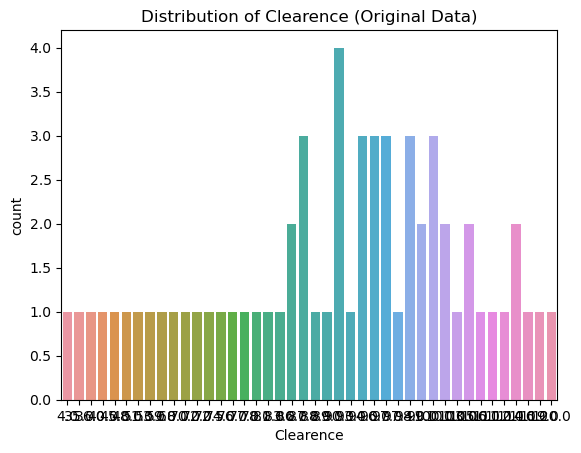

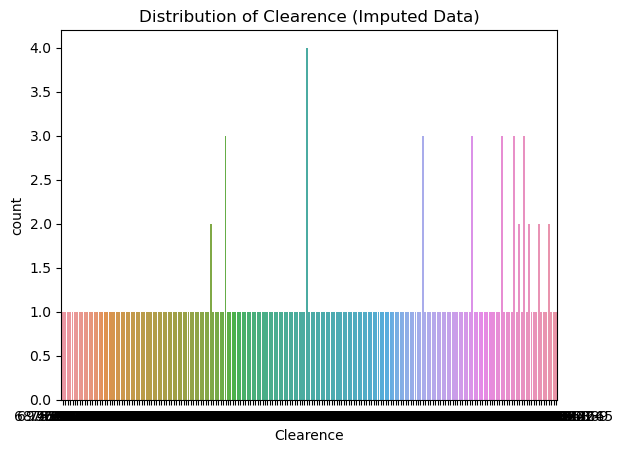

In [167]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency


# Tabella di contingenza
contingency_table = pd.crosstab(data['Clearence'], imputed_data['Clearence'])


# Test chi-quadrato
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi2 Statistic: {chi2}, p-value: {p}")

# Grafico a barre per i dati originali
sns.countplot(x='Clearence', data=data)
plt.title('Distribution of Clearence (Original Data)')
plt.show()

# Grafico a barre per i dati imputati
sns.countplot(x='Clearence', data=imputed_data)
plt.title('Distribution of Clearence (Imputed Data)')
plt.show()




Chi2 Statistic (2542.0): Questo valore rappresenta la differenza tra le distribuzioni osservate e attese delle variabili. Un valore così alto indica una grande discrepanza tra le due distribuzioni.
p-value (2.64750129357329e-38): Questo valore è estremamente piccolo, molto inferiore al livello di significatività comune (ad esempio, 0.05). Un p-value così basso suggerisce che c’è una probabilità molto bassa che la differenza osservata sia dovuta al caso.
I risultati indicano che c’è una differenza significativa tra la distribuzione della variabile categorica prima e dopo l’imputazione dei dati mancanti con missForest. Questo potrebbe suggerire che l’imputazione ha introdotto un cambiamento nella distribuzione dei dati.

In [174]:
# Conta il numero totale di valori NaN nel dataset
total_nan_count = data.isna().sum().sum()

# Calcola la percentuale di valori NaN nel dataset
total_nan_percentage = (total_nan_count / data.size) * 100

print(f"Total NaN Count: {total_nan_count}")
print(f"Total NaN Percentage: {total_nan_percentage:.2f}%")


Total NaN Count: 285
Total NaN Percentage: 0.11%


In [114]:
# Identifica le colonne con dati mancanti nel dataset originale
columns_with_missing = data.columns[data.isnull().any()]
print(columns_with_missing)
# Crea una copia del dataset completo per simulare i dati mancanti
simulated_data = imputed_data.copy()
#missing_mask = np.random.rand(*data_with_missing.shape) < 0.001  # Simula il 0.10% di valori mancanti
#data_with_missing[missing_mask] = np.nan
# Step 1: Simula i dati mancanti con un massimo di 240 valori mancanti distribuiti casualmente tra le colonne
np.random.seed(0)
n = 0
while n < 285:
    # Seleziona casualmente una colonna tra quelle con dati mancanti
    column = np.random.choice(columns_with_missing)
    # Seleziona casualmente un numero di valori da sostituire (tra 1 e il numero rimanente per raggiungere 240)
    r=random.randint(0, 100)
    i=0
    while i<r:
        # Seleziona casualmente gli indici da rimuovere
        random_indices = np.random.choice(simulated_data.index, 50, replace=False)
        # Imposta i valori selezionati a NaN se non sono già NaN
        for random_index in random_indices:
            if not pd.isna(simulated_data.loc[random_index, column]):
                simulated_data.loc[random_index, column] = np.nan
                n += 1
                i += 1
            if i>=r:
                break
    if n >= 285:
        break

Index(['PLT', 'HB', 'R_ISS', 'CREATININE', 'Clearence', 'PC_TOT', 'CALCIUM'], dtype='object')


In [116]:
# Split dataset into train and test sets.
train_simulated_data, test_simulated_data = train_test_split(simulated_data, test_size=.3, shuffle=True,
                               random_state=42)

# Default estimators are lgbm classifier and regressor
mf = MissForest()
mf.fit(
    x=train_simulated_data,
    categorical=["PFS_I_EVENT", "OS_EVENT", "SEX"]
)
train_imputed_missing = mf.transform(x=train_simulated_data)
test_imputed_missing = mf.transform(x=test_simulated_data)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.81it/s]


In [136]:
import numpy as np

def calculate_msep(original_data, data_without_missing, imputed_data, variables_to_check):
    msep_scores = {}
    
    for variable in variables_to_check:
        # Create a binary mask where missing values were originally located
        missing_mask = original_data[variable].isnull()
        print(missing_mask)
        # Extract the original and imputed values for the missing entries
        original_values = data_without_missing.loc[missing_mask, variable]
        imputed_values = imputed_data.loc[missing_mask, variable]
        
        # Calculate the MSEP score
        squared_errors = (original_values - imputed_values) ** 2
        percentage_errors = squared_errors / original_values ** 2
        msep = np.mean(percentage_errors) * 100  # Convert to percentage
        msep_scores[variable] = msep
    
    return msep_scores

# Esempio di utilizzo:
# Supponiamo che `data_with_missing` sia il dataset originale con valori mancanti
# e `missing_imputed` sia il dataset con i valori imputati da missForest

# Identifica le variabili con dati mancanti
variables_to_check = data_with_missing.columns[data_with_missing.isnull().any()]

# Calcola il MSEP per ogni variabile con dati mancanti
msep_results = calculate_msep(data_with_missing, imputed_data, missing_imputed, variables_to_check)

# Stampa i risultati del MSEP
for variable, msep in msep_results.items():
    print(f"MSEP for {variable}: {msep:.2f}%")


0      False
1      False
2      False
3      False
4      False
       ...  
216    False
217    False
218    False
219    False
220    False
Name: PFS_I_EVENT, Length: 221, dtype: bool
0      False
1      False
2      False
3      False
4      False
       ...  
216    False
217    False
218    False
219    False
220    False
Name: OS_EVENT, Length: 221, dtype: bool
0      False
1      False
2      False
3      False
4      False
       ...  
216    False
217    False
218    False
219    False
220    False
Name: PLT, Length: 221, dtype: bool
0      False
1      False
2      False
3      False
4      False
       ...  
216    False
217    False
218    False
219    False
220    False
Name: CREATININE, Length: 221, dtype: bool
0      False
1      False
2      False
3      False
4      False
       ...  
216    False
217    False
218    False
219    False
220    False
Name: original_shape_Flatness, Length: 221, dtype: bool
0      False
1      False
2      False
3      False
4      False


In [93]:
print(simulated_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Columns: 1145 entries, PFS_I_EVENT to wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis
dtypes: float64(1142), int64(3)
memory usage: 1.9 MB
None


In [115]:
# Identify columns with missing values
missing_columns = simulated_data.columns[simulated_data.isnull().sum() != 0]

# Print the columns with missing values and their respective counts
for col in missing_columns:
    print(f'{col}: {simulated_data[col].isnull().sum()}')
    print(f'{col}: {simulated_data[col].describe()}')


PLT: 3
PLT: count    218.000000
mean     228.504738
std       80.988564
min       35.000000
25%      181.000000
50%      217.500000
75%      274.000000
max      536.000000
Name: PLT, dtype: float64
HB: 63
HB: count    158.000000
mean      11.097260
std        1.890651
min        6.900000
25%        9.700000
50%       10.800000
75%       12.385000
max       15.700000
Name: HB, dtype: float64
CREATININE: 55
CREATININE: count    166.000000
mean       1.327302
std        1.622467
min        0.470000
25%        0.730000
50%        0.910000
75%        1.237500
max       13.400000
Name: CREATININE, dtype: float64
Clearence: 107
Clearence: count    114.000000
mean      87.242617
std       14.251694
min       35.000000
25%       84.850243
50%       90.000000
75%       95.256863
max      120.000000
Name: Clearence, dtype: float64
CALCIUM: 54
CALCIUM: count    167.000000
mean       9.684774
std        1.021794
min        8.300000
25%        9.100000
50%        9.500000
75%        9.966356
max    

In [ ]:
# Unisci i due dataframe mantenendo gli indici originali
imputed_simulated_data = pd.concat([train_imputed_missing, test_imputed_missing])

# Ordina gli indici in ordine crescente
imputed_simulated_data = imputed_simulated_data.sort_index()

In [119]:
print(simulated_data['PLT'])

0      301.0
1      118.0
2      243.0
3      256.0
4      237.0
       ...  
216    144.0
217    243.0
218    165.0
219    228.0
220    251.0
Name: PLT, Length: 221, dtype: float64


In [120]:
print(imputed_simulated_data['PLT'])

0      253.0
1      289.0
2      282.0
3      216.0
4      364.0
       ...  
216    152.0
217    233.0
218    340.0
219    189.0
220    187.0
Name: PLT, Length: 221, dtype: float64


In [123]:
print(train_simulated_data['PLT'])

65     253.0
112    289.0
186    282.0
155    216.0
31     364.0
       ...  
106    281.0
14     131.0
92     252.0
179    245.0
102    264.0
Name: PLT, Length: 154, dtype: float64


In [126]:
print(imputed_simulated_data['PLT'])

0      301.0
1      118.0
2      243.0
3      256.0
4      237.0
       ...  
216    144.0
217    243.0
218    165.0
219    228.0
220    251.0
Name: PLT, Length: 221, dtype: float64


In [63]:
# Supponiamo che `variables_to_check` sia la lista delle variabili per cui stai eseguendo il test
alpha_originale = 0.05
alpha_nuovo = alpha_originale / len(variables_to_check)
# Identifica le variabili con dati mancanti
variables_to_check = data_with_missing.columns[data_with_missing.isnull().any()]

for variable in variables_to_check:
    # Esempio per una variabile specifica
    
    # Test di Kolmogorov-Smirnov per una variabile specifica
    ks_stat, p_value = ks_2samp(data_with_missing[variable].dropna(), missing_imputed[variable])
    
    
    # Verifica se il p-value è significativo con la correzione di Bonferroni
    if p_value < alpha_nuovo:
        print(f"The result for {variable} is significant after Bonferroni correction.")
        print(f"KS Test for {variable}: KS Statistic = {ks_stat}, p-value = {p_value}")
        plot_distributions(data_with_missing, missing_imputed, variable)

    else:
        #print(f"The result for {variable} is not significant after Bonferroni correction.")
        continue


In [131]:
# Supponiamo che `simulated_data` e `imputed_data` siano i dataframe con i dati simulati e imputati

# Crea una maschera di valori mancanti tra simulated_data e imputed_data
missing_mask = simulated_data.isna() & imputed_data.notna()

# Stampa la maschera di valori mancanti per verificare
print(missing_mask)


     PFS_I_EVENT  PFS_I_MONTHS  OS_EVENT  OS_MONTH    PLT     HB    AGE  \
0          False         False     False     False  False   True  False   
1          False         False     False     False  False  False  False   
2          False         False     False     False  False  False  False   
3          False         False     False     False  False  False  False   
4          False         False     False     False  False   True  False   
..           ...           ...       ...       ...    ...    ...    ...   
216        False         False     False     False  False   True  False   
217        False         False     False     False  False  False  False   
218        False         False     False     False  False  False  False   
219        False         False     False     False  False  False  False   
220        False         False     False     False  False  False  False   

     R_ISS    SEX  CREATININE  ...  wavelet-LLL_gldm_GrayLevelNonUniformity  \
0    False  False   

In [135]:
# Step 3: Calcolo dell'RMSE
def calculate_rmse(original, imputed, mask):
    # Appiattisci i DataFrame per confrontare i valori
    original_flat = original.values.flatten()
    print(original_flat)
    imputed_flat = imputed.values.flatten()
    print(imputed_flat)
    # Filtra solo i valori che erano mancanti nell'originale
    original_missing = original_flat[mask.flatten()]
    print(original_missing)
    print(len(original_missing))
    imputed_missing = imputed_flat[mask.flatten()]
    print(imputed_missing)
    # Calcola l'RMSE
    rmse = np.sqrt(mean_squared_error(original_missing, imputed_missing))
    return rmse

# Esempio di utilizzo della funzione
rmse_value = calculate_rmse(imputed_data, imputed_simulated_data, missing_mask)
print(f"RMSE for missForest imputation: {rmse_value}")


[0.00000000e+00 2.40000000e+01 0.00000000e+00 ... 4.89531892e-01
 3.59572587e+03 1.26788235e-04]
[0.00000000e+00 2.40000000e+01 0.00000000e+00 ... 4.89531892e-01
 3.59572587e+03 1.26788235e-04]


AttributeError: 'DataFrame' object has no attribute 'flatten'

In [138]:
# Step 3: Calcolo dell'RMSE
def calculate_rmse(original, imputed, mask):
    # Appiattisci i DataFrame per confrontare i valori
    original_flat = original.values.flatten()
    imputed_flat = imputed.values.flatten()
    mask_flat = mask.values.flatten()
    print(mask_flat)
    # Filtra solo i valori che erano mancanti nell'originale
    original_missing = original_flat[mask_flat]
    imputed_missing = imputed_flat[mask_flat]
    
    # Calcola l'RMSE
    rmse = np.sqrt(np.mean((original_missing - imputed_missing) ** 2))
    return rmse

# Esempio di utilizzo
rmse_value = calculate_rmse(imputed_data, imputed_simulated_data, missing_mask)
print(f"RMSE: {rmse_value}")


[False False False ... False False False]
RMSE: 10.735757442995368


In [150]:
# Calcola l'RMSE per ogni variabile con valori mancanti
rmse_scores = {}
for column in columns_with_missing:
    print(column)
    original_values = imputed_data.loc[simulated_data[column].isnull(), column]
    #print(original_values)
    imputed_values = imputed_simulated_data.loc[simulated_data[column].isnull(), column]
    #print(imputed_values)
    original_flat = original_values.values.flatten()
    print(original_flat)
    imputed_flat = imputed_values.values.flatten()
    print(imputed_flat)
    if original_flat.any():
        rmse = np.sqrt(mean_squared_error(original_flat, imputed_flat))
        rmse_scores[column] = rmse

# Stampa i risultati dell'RMSE per ogni variabile
for column, rmse in rmse_scores.items():
    print(f"RMSE for {column}: {rmse}")

PLT
[299. 186. 116.]
[266.5651675  226.81679882 233.33061718]
HB
[13.6 12.5 12.   9.2 12.7 13.6 11.9  8.1 11.3 10.6 11.9 12.6 10.8  8.9
 13.2 11.8  9.3 10.3 12.5 11.3 10.8  9.  10.2  9.3  9.6 12.1  9.   8.8
 10.4 10.9  7.2 13.9  7.9 13.1 13.  12.8  7.7  9.9 12.1 13.  14.  11.7
 11.3 12.3  9.6 11.9 13.2 14.4 11.9  6.6  8.7 10.1 10.8  9.9  8.8  9.6
 11.3  9.5 11.   9.3  9.8  7.9 14.6]
[12.10642993 11.10070615 11.71920897 10.63252445 10.02369373 11.02233222
 10.98955493 10.55508342 10.32972873 10.81327932 10.23865835 12.20708568
 11.14477572 10.7822981  12.07939825 10.85885737 10.82996032 10.09442815
 11.08604969 11.40109894 10.88283903 10.21155106 10.79796202 11.04712247
 11.09829263 10.49789957 10.87824755 11.0574428  10.7343523  10.46560591
 10.61656533 11.79794556 10.62558944 10.75633378 11.14828644 11.41658832
  9.94483356 11.54341021 10.99943132 10.87821888 10.93942873 10.59558876
 10.45693008 11.60130547 10.57994482 10.48951286 11.67125537 11.12671358
 11.01221453  9.96557141 10.59

In [157]:
# Calcola gli errori relativi medi percentuali per ogni variabile con valori mancanti
percentage_errors = {}
for column in columns_with_missing:
    print(column)
    original_values = imputed_data.loc[simulated_data[column].isnull(), column]

    imputed_values = imputed_simulated_data.loc[simulated_data[column].isnull(), column]

    original_flat = original_values.values.flatten()

    imputed_flat = imputed_values.values.flatten()

    if original_flat.any():
        print(original_flat)
        print(imputed_flat)
        relative_errors = np.abs((original_flat - imputed_flat) / original_flat)
        print(relative_errors)
        percentage_error = np.mean(relative_errors) * 100
        percentage_errors[column] = percentage_error

# Stampa i risultati degli errori relativi medi percentuali per ogni variabile
for column, error in percentage_errors.items():
    print(f"Percentage Average Relative Error for {column}: {error:.2f}%")

PLT
[299. 186. 116.]
[266.5651675  226.81679882 233.33061718]
[0.1084777  0.21944515 1.01147084]
HB
[13.6 12.5 12.   9.2 12.7 13.6 11.9  8.1 11.3 10.6 11.9 12.6 10.8  8.9
 13.2 11.8  9.3 10.3 12.5 11.3 10.8  9.  10.2  9.3  9.6 12.1  9.   8.8
 10.4 10.9  7.2 13.9  7.9 13.1 13.  12.8  7.7  9.9 12.1 13.  14.  11.7
 11.3 12.3  9.6 11.9 13.2 14.4 11.9  6.6  8.7 10.1 10.8  9.9  8.8  9.6
 11.3  9.5 11.   9.3  9.8  7.9 14.6]
[12.10642993 11.10070615 11.71920897 10.63252445 10.02369373 11.02233222
 10.98955493 10.55508342 10.32972873 10.81327932 10.23865835 12.20708568
 11.14477572 10.7822981  12.07939825 10.85885737 10.82996032 10.09442815
 11.08604969 11.40109894 10.88283903 10.21155106 10.79796202 11.04712247
 11.09829263 10.49789957 10.87824755 11.0574428  10.7343523  10.46560591
 10.61656533 11.79794556 10.62558944 10.75633378 11.14828644 11.41658832
  9.94483356 11.54341021 10.99943132 10.87821888 10.93942873 10.59558876
 10.45693008 11.60130547 10.57994482 10.48951286 11.67125537 11.1267

In [158]:
# Calcola l'errore relativo medio percentuale per tutte le variabili con valori mancanti
original_values = []
imputed_values = []

for column in columns_with_missing:
    original_values.extend(imputed_data.loc[simulated_data[column].isnull(), column].values.flatten())
    imputed_values.extend(imputed_simulated_data.loc[simulated_data[column].isnull(), column].values.flatten())

original_values = np.array(original_values)
imputed_values = np.array(imputed_values)

relative_errors = np.abs((original_values - imputed_values) / original_values)
percentage_error = np.mean(relative_errors) * 100

# Stampa il risultato dell'errore relativo medio percentuale
print(f"Percentage Average Relative Error: {percentage_error:.2f}%")

Percentage Average Relative Error: 26.78%


In [173]:
# Creare una maschera per i valori mancanti sia in 'Creatinine' che in 'Clearence'
missing_both_mask = data['CREATININE'].isna() & data['Clearence'].isna()
print(missing_both_mask)
# Ottenere e stampare gli indici delle righe dove entrambi i valori sono mancanti
missing_indices = missing_both_mask[missing_both_mask].index
print("Indici delle righe dove sia la creatinina che la clearance sono mancanti:")
print(missing_indices)


0      False
1      False
2      False
3      False
4      False
       ...  
216    False
217    False
218    False
219    False
220    False
Length: 221, dtype: bool
Indici delle righe dove sia la creatinina che la clearance sono mancanti:
Int64Index([], dtype='int64')


In [ ]:
# Calcolo dell'accuratezza
correct_predictions = np.sum(data[missing_mask] == imputed_data[missing_mask])
total_predictions = np.sum(missing_mask)
accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0

print(f"Accuracy: {accuracy}")


In [59]:
def calculate_mae(original_data, data_without_missing, imputed_data, variables_to_check):
    mae_scores = {}
    
    for variable in variables_to_check:
        # Create a binary mask where missing values were originally located
        missing_mask = original_data[variable].isnull()
        
        # Extract the original and imputed values for the missing entries
        original_values = data_without_missing.loc[missing_mask, variable]
        imputed_values = imputed_data.loc[missing_mask, variable]
        
        # Calculate the MAE score
        mae = mean_absolute_error(original_values, imputed_values)
        mae_scores[variable] = mae
    
    return mae_scores

# Esempio di utilizzo:
# Supponiamo che `data_with_missing` sia il dataset originale con valori mancanti
# e `missing_imputed` sia il dataset con i valori imputati da missForest

# Identifica le variabili con dati mancanti
variables_to_check = data_with_missing.columns[data_with_missing.isnull().any()]

# Calcola il MAE per ogni variabile con dati mancanti
mae_results = calculate_mae(data_with_missing, imputed_data, missing_imputed, variables_to_check)

# Stampa i risultati del MAE
for variable, mae in mae_results.items():
    print(f"MAE for {variable}: {mae}")



MAE for PFS_I_EVENT: 1.0
MAE for OS_EVENT: 0.0
MAE for PLT: 134.0
MAE for CREATININE: 2.0
MAE for original_shape_Flatness: 0.028499169614360914
MAE for original_shape_MajorAxisLength: 29.827162586805343
MAE for original_shape_Sphericity: 0.003800818687307396
MAE for original_firstorder_Skewness: 0.886953114717927
MAE for original_glcm_ClusterProminence: 624469.482534979
MAE for original_glcm_DifferenceEntropy: 0.16935188492216158
MAE for original_glcm_DifferenceVariance: 0.7460568705662496
MAE for original_glcm_JointEnergy: 0.0007394101377393002
MAE for original_glcm_Idm: 0.022939910594726692
MAE for original_glcm_MaximumProbability: 0.007422353206966801
MAE for original_glcm_SumEntropy: 0.17708995701054686
MAE for original_glrlm_HighGrayLevelRunEmphasis: 16332.378396372218
MAE for original_glrlm_LongRunEmphasis: 0.12081579321780556
MAE for original_glrlm_ShortRunLowGrayLevelEmphasis: 0.0015578588956609368
MAE for original_glszm_GrayLevelNonUniformityNormalized: 0.001009090018424301
MA